<a href="https://colab.research.google.com/github/leem928/deeplearning/blob/master/car_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

zip_path = "/content/car.zip"
extract_path = "/content/car"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ 압축 해제 완료: {extract_path}")

✅ 압축 해제 완료: /content/car


In [2]:
import os
import json
import torch
from PIL import Image
from torchvision.transforms import functional as F

class CustomFasterRCNNDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))])

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name + ".json")  # 이미지와 같은 이름 + .json

        # 이미지 로드
        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        with open(label_path, 'r') as f:
            data = json.load(f)

        boxes = []
        labels = []

        for ann in data['annotations']:
            if 'bbox' in ann:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

In [3]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CustomFasterRCNNDataset(
    image_dir='/content/car/car_pedestrian/train/images',
    label_dir='/content/car/car_pedestrian/train/labels',
    transforms=ToTensor()
)

val_dataset = CustomFasterRCNNDataset(
    image_dir='/content/car/car_pedestrian/val/images',
    label_dir='/content/car/car_pedestrian/val/labels',
    transforms=ToTensor()
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 사전학습 모델 로드
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 클래스 수 (배경 포함 X)
num_classes = 101  # 예시로 category_id가 최대 100까지 있었음 → 실제 최대 ID+1로 설정해줘

# 기존 classifier를 새로 교체
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 191MB/s]


In [5]:
import torch
import torchvision
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss:.4f}")

100%|██████████| 140/140 [03:07<00:00,  1.34s/it]


[Epoch 1] Loss: 126.3049


100%|██████████| 140/140 [03:10<00:00,  1.36s/it]


[Epoch 2] Loss: 75.8295


100%|██████████| 140/140 [03:10<00:00,  1.36s/it]


[Epoch 3] Loss: 63.8895


100%|██████████| 140/140 [03:11<00:00,  1.36s/it]


[Epoch 4] Loss: 52.6042


100%|██████████| 140/140 [03:10<00:00,  1.36s/it]


[Epoch 5] Loss: 45.5278


100%|██████████| 140/140 [03:11<00:00,  1.36s/it]


[Epoch 6] Loss: 40.1534


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 7] Loss: 36.5052


100%|██████████| 140/140 [03:11<00:00,  1.36s/it]


[Epoch 8] Loss: 33.1577


100%|██████████| 140/140 [03:10<00:00,  1.36s/it]


[Epoch 9] Loss: 30.2113


100%|██████████| 140/140 [03:10<00:00,  1.36s/it]


[Epoch 10] Loss: 28.8112


100%|██████████| 140/140 [03:10<00:00,  1.36s/it]


[Epoch 11] Loss: 26.6331


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 12] Loss: 25.8445


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 13] Loss: 23.9503


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 14] Loss: 22.6910


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 15] Loss: 21.7430


100%|██████████| 140/140 [03:10<00:00,  1.36s/it]


[Epoch 16] Loss: 21.2256


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 17] Loss: 20.1524


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 18] Loss: 19.5959


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]


[Epoch 19] Loss: 18.4309


100%|██████████| 140/140 [03:11<00:00,  1.37s/it]

[Epoch 20] Loss: 18.5445


In [6]:
import matplotlib.pyplot as plt
import torch

def visualize_each_image(dataset, indices):
    model.eval()

    for idx in indices:
        image, _ = dataset[idx]
        image = image.to(device)

        with torch.no_grad():
            pred = model([image])[0]

        image_np = image.cpu().permute(1, 2, 0).numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(image_np)

        boxes = pred['boxes'].cpu()
        scores = pred['scores'].cpu()
        labels = pred['labels'].cpu()

        for box, score, label in zip(boxes, scores, labels):
            if score > 0.5:
                x1, y1, x2, y2 = box
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                                  edgecolor='red', facecolor='none', linewidth=2))
                plt.text(x1, y1 - 5, f"ID:{label.item()} {score:.2f}", color='yellow', fontsize=12)

        plt.title(f"Image {idx}")
        plt.axis('off')
        plt.show()

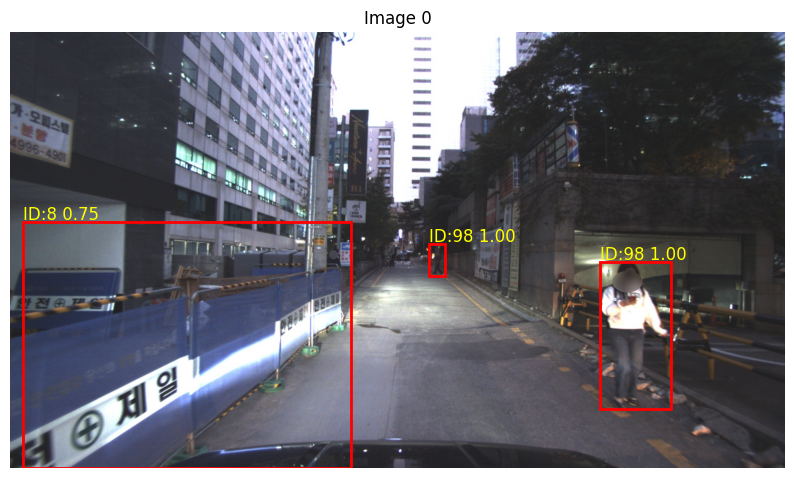

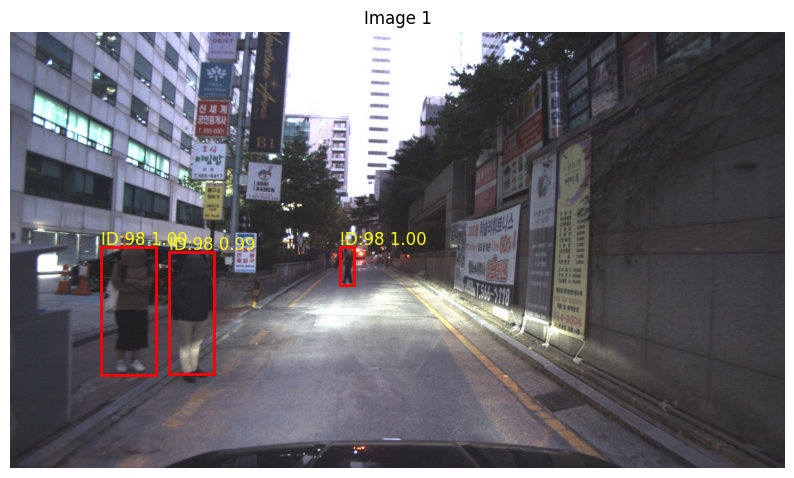

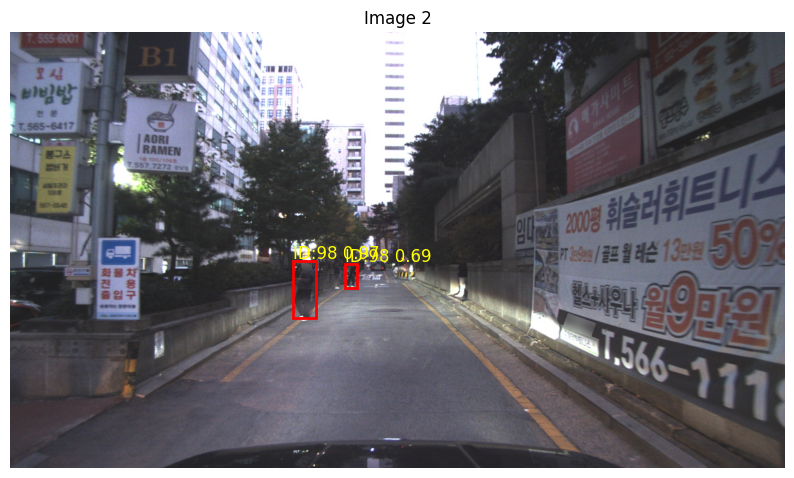

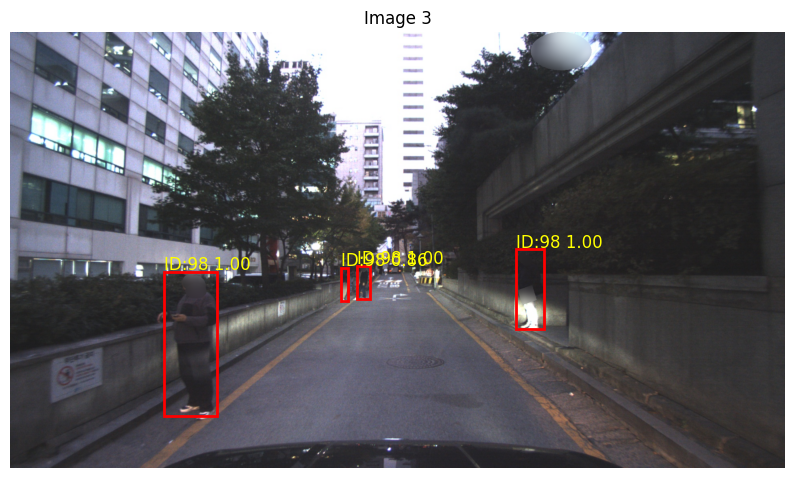

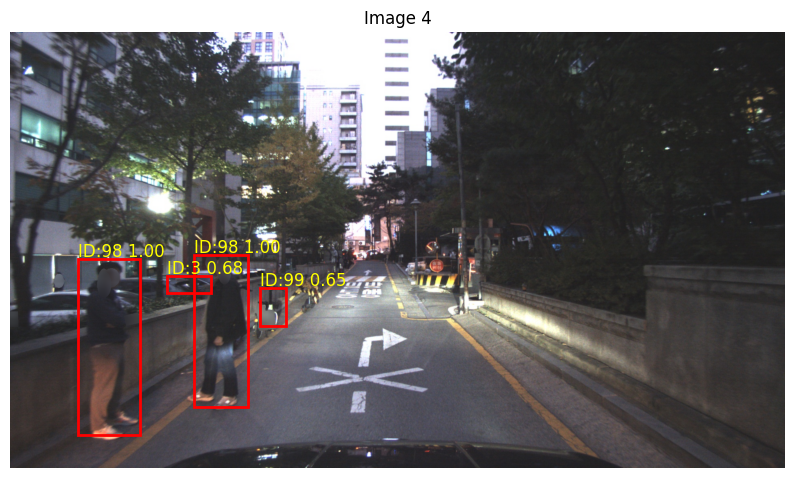

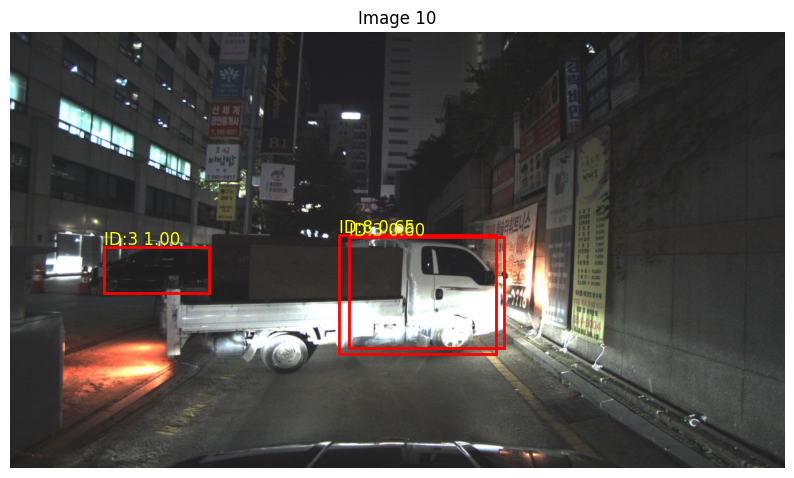

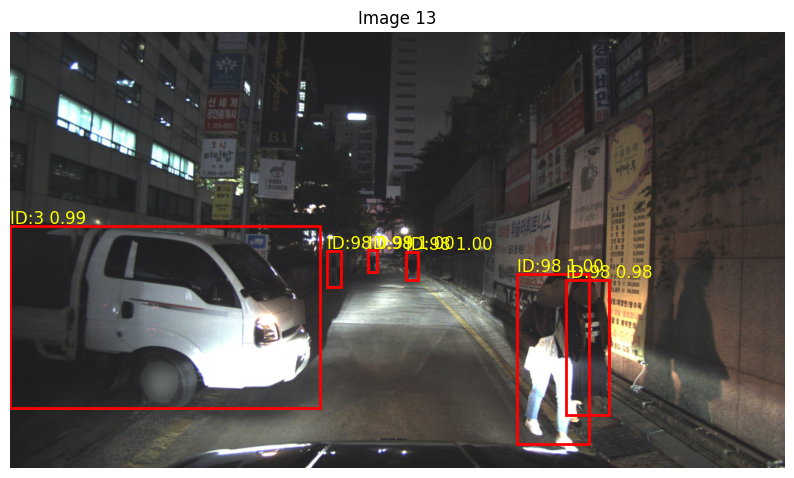

In [7]:
visualize_each_image(val_dataset, [0, 1, 2, 3, 4, 10, 13])

In [8]:
from torchvision.ops import box_iou
import torch

def evaluate_map(model, dataloader, device='cuda', iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    tp, fp, fn = 0, 0, 0
    ap_list = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for pred, gt in zip(outputs, targets):
                # Confidence score threshold 적용
                keep = pred["scores"] > score_threshold
                pred_boxes = pred["boxes"][keep]
                gt_boxes = gt["boxes"]

                if len(pred_boxes) == 0 and len(gt_boxes) == 0:
                    continue
                elif len(pred_boxes) == 0:
                    fn += len(gt_boxes)
                    ap_list.append(0)
                    continue
                elif len(gt_boxes) == 0:
                    fp += len(pred_boxes)
                    ap_list.append(0)
                    continue

                ious = box_iou(pred_boxes, gt_boxes)
                matches = ious > iou_threshold

                matched_gt = set()
                matched_pred = set()
                for pred_idx in range(matches.shape[0]):
                    for gt_idx in range(matches.shape[1]):
                        if matches[pred_idx, gt_idx] and gt_idx not in matched_gt:
                            matched_gt.add(gt_idx)
                            matched_pred.add(pred_idx)
                            break

                tp_batch = len(matched_gt)
                fp_batch = len(pred_boxes) - len(matched_pred)
                fn_batch = len(gt_boxes) - len(matched_gt)

                tp += tp_batch
                fp += fp_batch
                fn += fn_batch

                # 간단한 AP 근사값 (TP / (TP+FP+FN))
                ap = tp_batch / (tp_batch + fp_batch + fn_batch + 1e-6)
                ap_list.append(ap)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    map50 = sum(ap_list) / len(ap_list) if ap_list else 0.0

    print(f"\n📊 평가 결과 (IoU > {iou_threshold}, Score > {score_threshold} 기준):")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"mAP@0.5     : {map50:.4f}")

In [10]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

In [11]:
evaluate_map(model, val_dataloader, device='cuda', iou_threshold=0.5, score_threshold=0.5)


📊 평가 결과 (IoU > 0.5, Score > 0.5 기준):
Precision   : 0.7318
Recall      : 0.7759
F1 Score    : 0.7532
mAP@0.5     : 0.6312
